# My Deep Learning Framework

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Labels
- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

In [2]:
articles = {
            0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 
            5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

def get_article(id):
    return articles.get(id)

## Loading Fashion MNIST data

### Working with pandas and numpy

In [3]:
base_data_path = 'fashion-mnist-data'
df = pd.read_csv(f'./{base_data_path}/fashion-mnist_train.csv')
df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Building the Neural Network

In [84]:
def init_params(batch_size: int, layers_neurons: list):
    W1 = np.random.randn(batch_size, layers_neurons[0])
    b1 = np.zeros(shape=(batch_size, 1))

    W2 = np.random.randn(layers_neurons[1], batch_size)
    b2 = np.zeros(shape=(layers_neurons[1], 1))

    W3 = np.random.randn(layers_neurons[2], layers_neurons[1])
    b3 = np.zeros(shape=(layers_neurons[2],1))
    
    return W1, b1, W2, b2, W3, b3

def relu(x):
    return np.maximum(x, 0)

def softmax(x):
    z = x - np.max(x, axis=0)
    probs = np.exp(z) / np.sum(np.exp(z), axis=0)
    return probs

def cross_entropy_loss(y_hat, y_one_hot):
    # y_one_hot es un vector con las probabilidades reales (etiquetas verdaderas)
    # y_hat es un vector con las probabilidades predichas por el modelo
    epsilon = 1e-15  # Valor pequeño para evitar divisiones por cero
    y_hat = np.maximum(epsilon, y_hat)  # Asegurarse de que no haya valores cercanos a cero
    return - np.sum(y_one_hot * np.log(y_hat))

def relu_prime(z):
    #z[ z <= 0] = 0
    return z > 0

def one_hot(y, k=10):
    #one_hot_y = np.zeros(shape=(y.size, k))
    #classes = np.arange(y.size)
    #one_hot_y[classes, y] = 1
    one_hot_y = np.zeros((y.size, 10)) # 10 classes
    one_hot_y[np.arange(y.size), y] = 1
    # return the same format as 784 x batch_size
    return one_hot_y.T

def forward_propagation(X, W1, b1, W2, b2, W3, b3):
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = softmax(Z3)

    return Z1, A1, Z2, A2, Z3, A3

def backward_propagation(X, Y_one_hot, Z1, A1, Z2, A2, Z3, A3, W1, W2, W3):
    m = X.shape[1] # samples 

    dZ3 = A3 - Y_one_hot
    dW3 = 1/m * (dZ3 @ A2.T)
    db3 = 1/m * np.sum(dZ3, 1)

    dA2 = W3.T @ dZ3
    dZ2 = dA2 * relu_prime(Z2)
    dW2 = 1/m * (dZ2 @ A1.T)
    db2 =  1/m * np.sum(dZ2, 1)

    dA1 = W2.T @ dZ2
    dZ1 = dA1 * relu_prime(Z1)
    dW1 = 1/m * (dZ1 @ X.T)
    db1 = 1/m * np.sum(dZ1, 1)

    return dW1, db1, dW2, db2, dW3, db3

def update_params(lr: float,layers_neurons: list, W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3):
    W1 = W1 - lr * dW1
    b1 = b1 - lr * db1.reshape(len(W1),1)
    W2 = W2 - lr * dW2
    b2 = b2 - lr * db2.reshape(layers_neurons[1],1)
    W3 = W3 - lr * dW3
    #print(f"b3: {b3.shape}, db3: {db3.shape}")
    b3 = b3 - lr * db3.reshape(layers_neurons[2], 1)
    return W1, b1, W2, b2, W3, b3

def get_batches(total_samples, batch_size=16):
    batches = []
    for split in range(0, total_samples, batch_size):
        if split + batch_size > total_samples: break
        start_index = split
        end_index = split + batch_size #if (split + batch_size <= total_samples)  else  total_samples
        batches.append((start_index, end_index))
    return batches

def get_accuracy(y_hat, y):
    predictions = np.argmax(y_hat, 0)
    return np.sum(predictions == y) / y.size

#get_batches(100)

#A = [[-1, 0.5, -0.23], [0.67, -2.8, 2.12]]
#print(relu(A))
#print(softmax(A))

input_vector = np.array([2, 1.0, 0.1])
softmax(input_vector)

array([0.65900114, 0.24243297, 0.09856589])

In [76]:
#TOTAL_SAMPLES = 6000 # it could be the total number
TEST_SAMPLES = 1000

data = np.array(df)
#data = data[0:TOTAL_SAMPLES,] # limiting the train samples
m, n = data.shape # 60000, 785 # 6000 x 785
np.random.shuffle(data)

data_test = data[0:TEST_SAMPLES].T # 785, 1000 
X_test = data_test[1:n] 
Y_test = data_test[0]

data_train = data[TEST_SAMPLES:].T
X_train = data_train[1:n]
Y_train = data_train[0]

# Normalization
X_test = X_test / 255
X_train = X_train / 255

Creating a Neural Network with:
- 3 layers: 1 input, 1 hidden, 1 output
- hidden layer

In [85]:
# Hyperparams
batch_size = 100
epochs = 300
learning_rate = 0.05

layers_neurons = [784, 25, 10]
total_samples = len(Y_train)
errors = []

def train():
    X = X_train
    Y = Y_train

    W1, b1, W2, b2, W3, b3 = init_params(batch_size, layers_neurons)

    for epoch in range(epochs):
        
        for i in range(0, total_samples, batch_size):
            X_batch = X[ :, i: i + batch_size ]
            Y_batch = Y[ i: i + batch_size ]
            Z1, A1, Z2, A2, Z3, A3 = forward_propagation(X_batch, W1, b1, W2, b2, W3, b3)
            y_one_hot = one_hot(Y_batch)
            loss = cross_entropy_loss(A3, y_one_hot) # y_hat - y

            dW1, db1, dW2, db2, dW3, db3 = backward_propagation(X_batch, y_one_hot, Z1, A1, Z2, A2, Z3, A3, W1, W2, W3)
            W1, b1, W2, b2, W3, b3 = update_params(learning_rate, layers_neurons, W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3)
        
        if epoch == 0 or (epoch + 1) % 50  == 0:
            #acc = get_accuracy(A3, Y)
            print(f"Epoc: {epoch + 1}, loss: {round(loss,4)}")
        errors.append(loss)
            
    return W1, b1, W2, b2, W3, b3
    
W1, b1, W2, b2, W3, b3 = train()

Epoc: 1, loss: 198.0333


KeyboardInterrupt: 

#### Analyzing Epochs and Loss

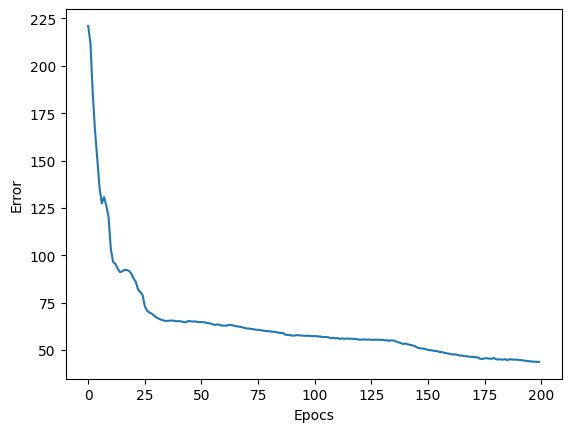

In [43]:
import matplotlib.pyplot as plt
plt.xlabel('Epocs')
plt.ylabel('Error')
plt.plot(errors)

## Inferences

In [74]:
X_test.shape
X_test[:, 10, None ].shape
X_test[: , 10].shape
W1.shape, X_test[: , 10].reshape(784, 1).shape

((100, 784), (784, 1))

In [82]:
random_item = 10
Y_item_test = Y_test[random_item]
X_item_test = X_test[:, random_item ].reshape( 784, 1) # X_test[:, random_item, None]

Y_item_test, get_article(Y_item_test)

(8, 'Bag')

In [83]:
def predict(index, X, W1, b1, W2, b2, W3, b3):
    _, _, _, _, _, A3 = forward_propagation(X, W1, b1, W2, b2, W3, b3)
    predictions = np.argmax(A3, axis=1)
    return predictions[index]

item_predicted = predict(random_item, X_item_test, W1, b1, W2, b2, W3, b3)
item_predicted
item_predicted, get_article(item_predicted)

ValueError: shapes (1,784) and (100,784) not aligned: 784 (dim 1) != 100 (dim 0)

In [50]:
#X_test[:, random_item, None].shape
_, _, _, _, _, A3 = forward_propagation(X_item_test, W1, b1, W2, b2, W3, b3)
A3.shape

(10, 100)

#### Actual Image

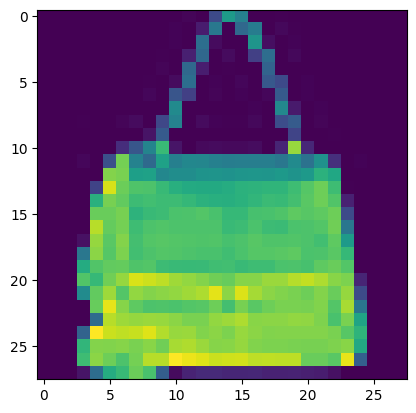

In [45]:
img = X_item_test.reshape((28, 28)) * 255
plt.imshow(img)
plt.show()